#### Install MATES and required packages

In [1]:
%%bash
git clone https://github.com/mcgilldinglab/MATES.git
conda create -n mates_env python=3.9
conda activate mates_env
conda install -c bioconda samtools
pip install pysam
conda install -c bioconda bedtools
pip install pybedtools
cd MATES
pip3 install -r requirements.txt 
python setup.py install
pip install .
pip install velocyto

conda install ipykernel
python -m ipykernel install --user --name=mates_env

Cloning into 'MATES'...


In [1]:
import warnings
warnings.filterwarnings("ignore")

**Download the sample data to the same folder of this notebook.**

#### Build TE reference (this may takes a few minutes)

In [2]:
%%bash
### Edit the path to build_reference.py according to where you place this notebook
python ../build_reference.py --species Mouse

--2024-07-09 12:42:21--  https://www.repeatmasker.org/genomes/mm10/RepeatMasker-rm405-db20140131/mm10.fa.out.gz
Resolving www.repeatmasker.org (www.repeatmasker.org)... 174.127.185.143
Connecting to www.repeatmasker.org (www.repeatmasker.org)|174.127.185.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167976211 (160M) [application/x-gzip]
Saving to: ‘mm10.fa.out.gz’

     0K .......... .......... .......... .......... ..........  0%  378K 7m14s
    50K .......... .......... .......... .......... ..........  0% 1.00M 4m57s
   100K .......... .......... .......... .......... ..........  0% 2.48M 3m39s
   150K .......... .......... .......... .......... ..........  0% 29.7M 2m46s
   200K .......... .......... .......... .......... ..........  0%  316K 3m56s
   250K .......... .......... .......... .......... ..........  0% 2.00M 3m30s
   300K .......... .......... .......... .......... ..........  0%  306M 3m0s
   350K .......... .......... .......... .......

#### Process aligned bam files

In [3]:
from MATES import bam_processor

In [4]:
bam_processor.split_bam_files('10X', 1, 'test_samplelist.txt', 'test_bam_path.txt',bc_ind = 'CR', bc_path_file='test_cb_path.txt')

Directory ./file_tmp created.
Directory ./bam_tmp created.
Directory ./bc_tmp created.
Start splitting bam files into unique/multi reads sub-bam files ...
Directory ./unique_read created.
Directory ./multi_read created.
Finish splitting bam files into unique reads and multi reads sub-bam files.
Start splitting multi sub-bam based on cell barcodes...
Finish splitting unique sub-bam.
Finish splitting multi sub-bam.
Directory ./file_tmp removed.
Directory ./bam_tmp removed.
Directory ./bc_tmp removed.


In [5]:
bam_processor.count_coverage_vec('exclusive', '10X', 5, 'test_samplelist.txt', ref_path = 'Default', bc_path_file='test_cb_path.txt')

Directory ./tmp created.
Directory ./count_coverage created.
Directory ./count_coverage/test created.
Finish batch 0:10/11 for sample test
Finish batch 0:11/11 for sample test
Finish batch 3:10/11 for sample test
Finish batch 3:11/11 for sample test
Finish batch 1:10/11 for sample test
Finish batch 1:11/11 for sample test
Finish batch 2:10/11 for sample test
Finish batch 2:11/11 for sample test
Directory ./tmp removed.


#### Generate data for model

In [6]:
from MATES import data_processor

In [7]:
data_processor.calculate_UM_region('exclusive', '10X', 'test_samplelist.txt', bin_size=5, proportion=80, ref_path = 'Default', bc_path_file='test_cb_path.txt')

Directory MU_Stats created.
Start Calculating U/M region for cells in test...


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 13.16it/s]

Finish calculating U/M region for cells in test, finalizing...
Finish finalizing U/M region information for test.


In [8]:
data_processor.generate_training_sample('10X', 'test_samplelist.txt', bin_size=5, proportion=80)

Start generating training sample for unqiue read TE in test...
Finish analyse generating sample for unqiue read TE in test.
Start generating training sample for multi read TE in test...
Finish analyse generating sample for multi read TE in test.
Finish Sample test


In [9]:
data_processor.generate_prediction_sample('exclusive', '10X', 'test_samplelist.txt', bin_size=5, proportion=80, ref_path = 'Default', bc_path_file='test_cb_path.txt')

Directory MU_Stats created.
Start analyse full prediciton data of multi read...


100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  4.21it/s]

(11445, 3)


100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]

Finish analyse full prediciton data of multi read.
Finish saving data for prediction.


#### Training and prediction

In [1]:
from MATES import MATES_model

CUDA device 'cuda:0' is available.
Data Mode:  10X
AE Settings:  Epoch:    150, Learning Rate: 0.000001
MLP Settings: Epoch:    150, Learning Rate: 0.000001
Batch Size:     36
Searching Bin Size:      5
Dominate Proportion:     80
Loading training data for test...
Training model for test...


100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 23.06it/s]


Finish training model for test.


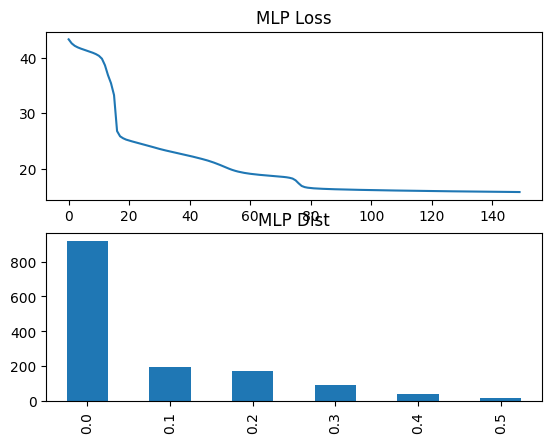

In [3]:
MATES_model.train('10X', 'test_samplelist.txt', bin_size = 5, proportion = 80, BATCH_SIZE= 36, AE_LR = 1e-6, MLP_LR = 1e-6, AE_EPOCHS = 150, MLP_EPOCHS = 150, DEVICE= 'cuda:0')

In [7]:
MATES_model.prediction('exclusive', '10X', 'test_samplelist.txt', bin_size = 5, proportion = 80, AE_trained_epochs =150, MLP_trained_epochs=150, DEVICE= 'cuda:0', ref_path = 'Default')

CUDA device 'cuda:0' is available.
start calculating


 92%|███████████████████████████████████████▍   | 11/12 [00:00<00:00, 54.53it/s]
/mnt/md0/ruohan/anaconda3/envs/mates_env/lib/python3.9/site-packages/MATES/scripts/make_prediction.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['TE_index'] = tmp['TE_index'].astype(int)


Finish quantify Multi TE


In [8]:
MATES_model.prediction_locus('exclusive', '10X', 'test_samplelist.txt', bin_size=5, proportion=80, AE_trained_epochs=150, MLP_trained_epochs=150, DEVICE= 'cuda:0', ref_path = 'Default')

CUDA device 'cuda:0' is available.
start calculating
11445


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 57.20it/s]


Finish quantify Multi TE


#### TE quantification

In [9]:
from MATES import TE_quantifier

In [10]:
TE_quantifier.unique_TE_MTX('exclusive', '10X', 'test_samplelist.txt', 1, ref_path = 'Default', bc_path_file='test_cb_path.txt')

 98%|█████████▊| 49/50 [00:48<00:00,  1.36it/s]

Combining batchly quntified Unique TE MTX...
Finish finalizing Unique TE MTX.


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


In [11]:
TE_quantifier.finalize_TE_MTX('10X', 'test_samplelist.txt')

Start create TE_MTX for test ...
Finish create TE_MTX for  test


In [12]:
TE_quantifier.quantify_locus_TE_MTX('exclusive', '10X', 'test_samplelist.txt')

Finish finalizing Unique TE MTX for test
Finalizing locus expression matrix for test...
Finis finalizing locus expression matrix for test.


/mnt/md0/ruohan/anaconda3/envs/mates_env/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/md0/ruohan/anaconda3/envs/mates_env/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/md0/ruohan/anaconda3/envs/mates_env/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/md0/ruohan/anaconda3/envs/mates_env/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/md0/ruohan/anaconda3/envs/mates_env/lib/python3.9/site-packages/sci